In [10]:
#
# Warning: make sure to allocate sufficient memory to run this notebook.
#
##### Set the SLURM job IDs here ####

JOB_ID = '8008310v2' #'8209068'



#### Should not need to change the following lines ####

%matplotlib inline
import os, sys
import torch
import configargparse
import numpy as np
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src/experiment_scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)
from aNiMAte.src.experiment_scripts.main import init_config
from aNiMAte.src.atomic_utils import AtomicModel
from aNiMAte.src.dynamics_utils import DynamicsModelNMA
from aNiMAte.src.prody_utils import read_prody_model
from prody import writePDB
import pykeops


EVAL_PATH = f'../logs/{JOB_ID}/eval/'
CONFIG_PATH =  f'../logs/{JOB_ID}_0/config.ini'

pykeops.set_verbose(False)
pykeops.set_build_folder('tmp/pykeops')

gt = torch.load(os.path.join(EVAL_PATH, 'gt.pt'), map_location=torch.device('cpu'))
inp = torch.load(os.path.join(EVAL_PATH, 'input.pt'), map_location=torch.device('cpu'))
pred = torch.load(os.path.join(EVAL_PATH, 'output.pt'), map_location=torch.device('cpu'))

parser = configargparse.ArgParser()
parser.add_argument('-c', '--config', required=True, is_config_file=True,
                    help='Path to config file.', default=CONFIG_PATH)
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
init_config(parser)  # use the default arguments from main.init_config to stay synchronized
config = parser.parse_args()

atomic_model = AtomicModel(config.atomic_pdb, config.atomic_clean_pdb, config.atomic_center,
                                   pdb_out=os.path.join('.', 'curated_gemmi.pdb'))
atomic_model = DynamicsModelNMA(atomic_model, atomic_clean_pdb=config.atomic_clean_pdb,
                                atomic_cg_selection=config.atomic_cg_selection,
                                atomic_nma_cutoff=config.atomic_nma_cutoff,
                                atomic_nma_gamma=config.atomic_nma_gamma,
                                atomic_nma_number_modes=config.atomic_nma_number_modes,
                                atomic_nma_pkl=config.atomic_nma_pkl if "atomic_nma_pkl" in config else None,
                                by_chain=config.atomic_nma_by_chain)
prody_model = read_prody_model('curated_gemmi.pdb')

## Visualize a projection prediction

MSE = 6.958727524647312


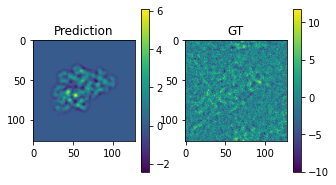

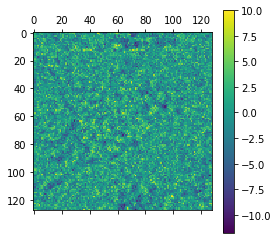

In [11]:
gt_projection = np.squeeze(gt['proj'][0].numpy())
pred_projection = np.squeeze(pred['proj'][0].numpy())

diff = pred_projection-gt_projection

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].set_title("Prediction")
img = axes[0].imshow(pred_projection)
fig.colorbar(img, ax=axes[0])
axes[1].set_title("GT")
img2 = axes[1].imshow(gt_projection)
fig.colorbar(img2, ax=axes[1])


plt.matshow(diff)
plt.colorbar()
print(f"MSE = {(diff**2).mean()}")

### Plot NMA coordinates

(139722, 1, 16)


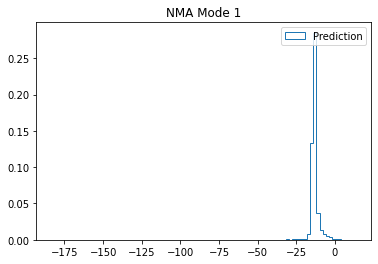

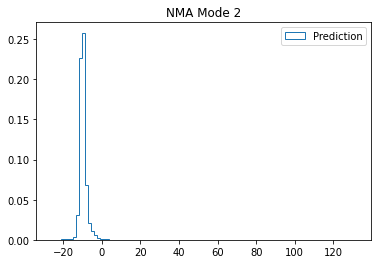

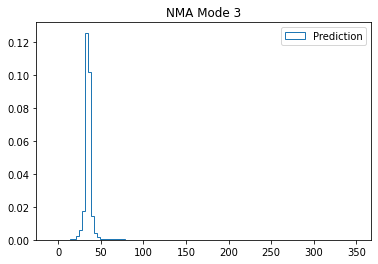

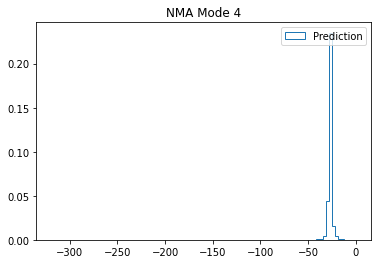

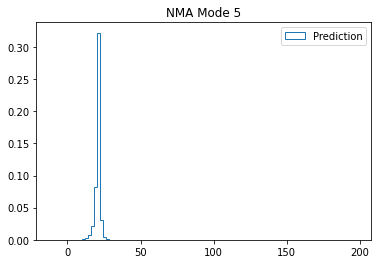

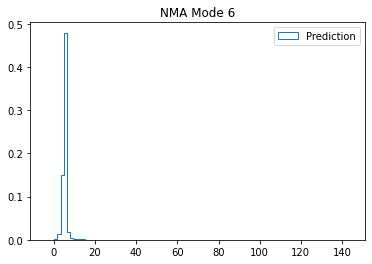

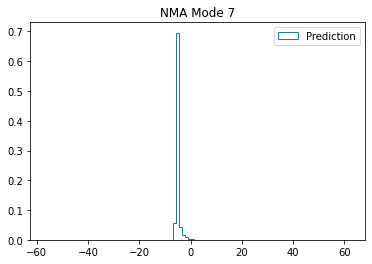

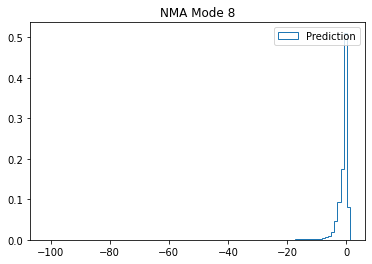

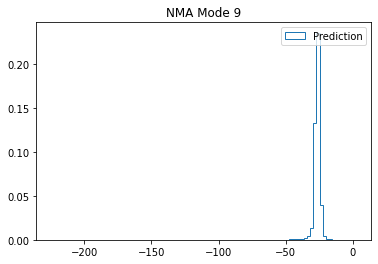

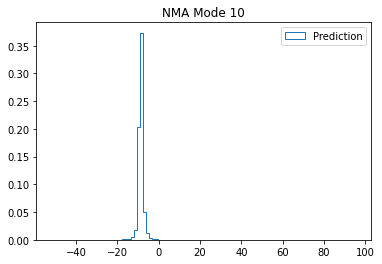

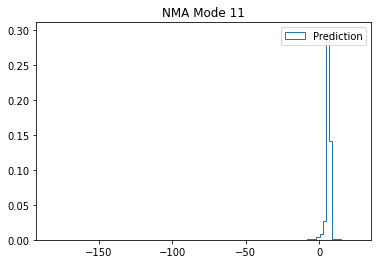

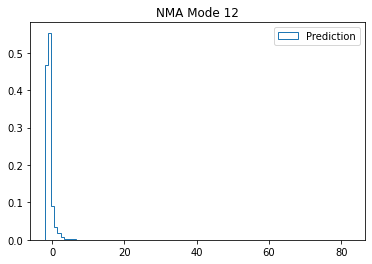

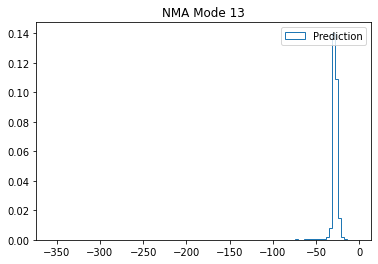

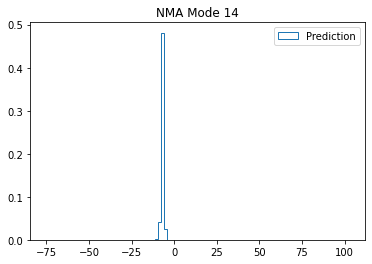

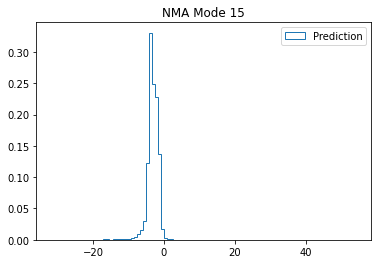

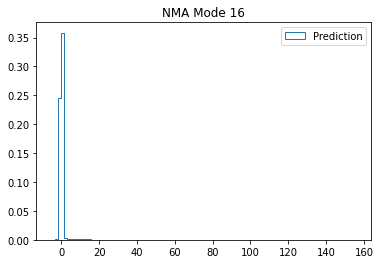

In [12]:
import seaborn as sns
from sklearn.decomposition import PCA
   
plot_all_modes = True
pred_nma_coords = (pred['nma_coords'].numpy()).copy()
if config.atomic_global_nma:
    print(pred['global_nma_coords'][0].numpy())
    pred_nma_coords += (pred['global_nma_coords'].numpy())


def filter_nma(pred_nma_coords, sigma_factor=3.0):
    filter_idx = []
    for i in range(pred_nma_coords.shape[-1]):
        filter_idx.extend(np.where(abs(pred_nma_coords[...,i] - np.median(pred_nma_coords[...,i]))
                           > sigma_factor * pred_nma_coords[...,i].std())[0])
    filter_idx = np.unique(np.array(filter_idx))
    if filter_idx.shape[0] == 0:
        return pred_nma_coords, None
    return np.delete(pred_nma_coords, filter_idx, 0), filter_idx

filter_idx = None
# pred_nma_coords, filter_idx = filter_nma(pred_nma_coords, 1.)
print(pred_nma_coords.shape)

sim = False
if 'nma_alphas' in gt.keys():
    gt_nma_coords = (gt['nma_alphas'].numpy()).copy()
    c = np.squeeze(gt['pdb_index'].cpu().numpy())
    if filter_idx is not None:
        c = np.delete(c, filter_idx, 0)
    num_atoms = prody_model.getCoords().shape[0]
    n_modes = pred_nma_coords.shape[2]
    gt_nma_coords /= np.sqrt(num_atoms/n_modes)
    sim = True
elif 'nma_coords' in gt.keys():
    gt_nma_coords = (gt['nma_coords'].numpy()).copy()
    sim = True
if sim and filter_idx is not None:
    gt_nma_coords = np.delete(gt_nma_coords, filter_idx, 0)
    
pca = None
if pred_nma_coords.shape[-1] > 1 and not plot_all_modes:
    pred_nma_coords = np.squeeze(pred_nma_coords)
    pca = PCA(n_components=1)
    pred_nma_coords = pca.fit_transform(pred_nma_coords) #TSNE(n_components=1, learning_rate='auto', init='pca').fit_transform(pred_nma_coords)
    print(pred_nma_coords.shape)
    
for i in range(pred_nma_coords.shape[-1]):
    pred_nma = pred_nma_coords[...,i]
    if(pred_nma.ndim > 1):
        pred_nma = np.squeeze(pred_nma)
    if sim:
        gt_nma = gt_nma_coords[...,i]
        plt.figure()
        plt.title(f'NMA Mode {i+1}')
        plt.scatter(gt_nma, pred_nma, alpha=0.5, label='prediction')
        plt.plot(gt_nma, gt_nma, color='r', label="perfect")
        plt.legend()
        ax = sns.jointplot(x=c, y=pred_nma, kind="kde", fill=True, cmap='Blues')
        ax.set_axis_labels('Ground Truth Model',
                           f'PC 1: EV({pca.explained_variance_ratio_[0]})' if pca else 'Mode 1 Amplitudes')
#         sns.jointplot(x=c, y=pred_nma, kind="scatter", alpha=0.1)
    plt.figure()
    plt.title(f'NMA Mode {i+1}')
    if sim:
        plt.hist(gt_nma, bins=50, density=True, label='GT')
    plt.hist(pred_nma, bins=100, histtype='step', density=True, label='Prediction')
    plt.legend()

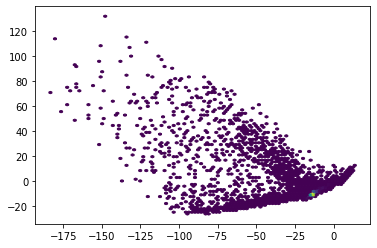

In [13]:
plt.hexbin(pred_nma_coords[...,0],pred_nma_coords[...,1],mincnt=1)
plt.show()

### Save Conformations to PDB

(122590, 16)
torch.Size([2, 1, 16])


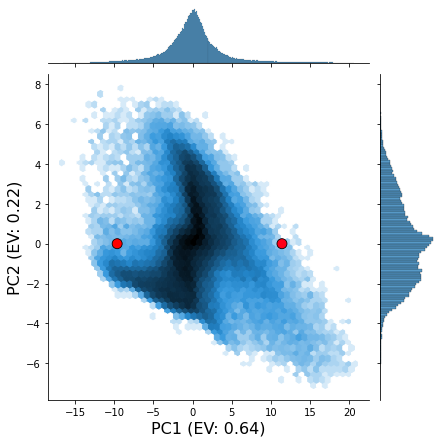

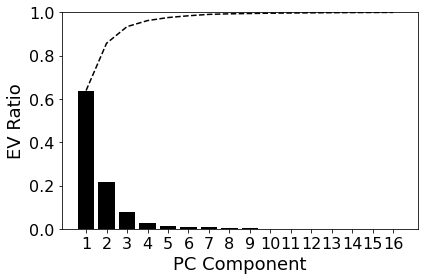

In [14]:
%matplotlib inline
from sklearn.decomposition import PCA

sample = 2 # how many frames (atomic models) to sample from latent space
sample_frac = 0.99 # for uniform sampling, use the (1-frac) percentile to (frac) percentile
uniform_sampling = True


z = np.squeeze(pred['nma_coords'].cpu().numpy())
if config.atomic_global_nma:
    z += (pred['global_nma_coords'].numpy()).squeeze()
z, _ = filter_nma(z, 1.)
print(z.shape)
pca = PCA(z.shape[1])
pca.fit(z)
pc = pca.transform(z)

ii,jj = [0, 1]

s = np.zeros((sample, z.shape[1]))
if uniform_sampling:
    s[:,ii] = np.linspace(np.quantile(pc[:,ii], 1-sample_frac), 
                          np.quantile(pc[:,ii], sample_frac), sample)
else:
    si = np.random.choice(pc.shape[0], sample, replace=False)
    s[:,ii] = pc[si, ii]
    s[:,jj] = pc[si, jj]
    s = s[np.argsort(s[:,ii])]

plot = sns.jointplot(x=pc[:,ii], y=pc[:,jj], kind="hex", bins="log")
plot.set_axis_labels('PC{} (EV: {:.2f})'.format(ii+1, pca.explained_variance_ratio_[ii]),
                     'PC{} (EV: {:.2f})'.format(jj+1, pca.explained_variance_ratio_[jj]), fontsize=16)
sns.scatterplot(x=s[:,ii], y=s[:,jj], c=np.arange(len(s)), cmap='hsv', edgecolor='k', s=100, ax=plot.ax_joint)

x = pca.inverse_transform(s)

sampled_pred = torch.as_tensor(x, dtype=torch.float32)[:, None, :]
    
print(sampled_pred.shape)

pred_coords = atomic_model(sampled_pred)[0]

traj = prody_model.copy()
for pred_coordset in pred_coords:
    traj.addCoordset(pred_coordset)
writePDB("pred_trajectory.pdb", traj, hybrid36=True)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.figure()
plot=sns.barplot(x=np.arange(len(exp_var_pca))+1,y=exp_var_pca, color='k', label='Individual EV')
plt.plot(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, label='Cumulative EV', color='k', ls='--')
# plt.legend(loc='best')
plt.xlabel('PC Component', fontsize=18)
plt.ylabel('EV Ratio', fontsize=18)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.ylim([0, 1.]);
plt.tight_layout()

plot.figure.savefig("PCA_EV.png", dpi=200, bbox_inches='tight')